# Modelowanie układów przepływowych
### Sylwester Arabas, Agnieszka Żaba, Mirosław Zimnoch
### ćwiczenia 2 (5/6.XI.2025): rozszerzenie kodu UPWIND 2D (wykł. 3) do MPDATA 2D

# Materiał z wykładu:

In [1]:
!pip install --quiet open_atmos_jupyter_utils

In [2]:
from collections.abc import Iterable, Callable
import numpy as np
from matplotlib import pyplot, colors, cm
from open_atmos_jupyter_utils import show_anim

#### 0. umożliwienie operacji typu `i+one`, `i-half` dla `i` typu `slice`:

In [11]:
class Shift():
    def __init__(self, plus: int, minus: int):
        self.plus = plus
        self.minus = minus
    def __radd__(self, arg: slice):
        return slice(arg.start + self.plus, arg.stop  + self.plus)
    def __rsub__(self, arg: slice):
        return slice(arg.start - self.minus, arg.stop  - self.minus)

one = Shift(1, 1)
half = Shift(0, 1)

#### 1. logika rozszerzania zakresu `slice` (np. `extend(slice(0,1), half)`)

In [12]:
def extend(r: slice, n: int | Shift):
    if type(n) == int and n == 1:
        n = one
    return slice((r - n).start, (r + n).stop)

#### 2. permutacje indeksów, schemat numeryczny UPWIND

In [13]:
def pi(d: int, *arg: slice):
    return arg[d], arg[d-1]

def f(psi_l: np.ndarray, psi_r: np.ndarray, C: np.ndarray):
    return ((C + abs(C)) * psi_l + (C - abs(C)) * psi_r) / 2

def upwind(d: int, psi: np.ndarray, C: np.ndarray, i: slice, j: slice):
    return (
        f(psi[pi(d, i,       j)], psi[pi(d, i + one, j)], C[pi(d, i + half, j)]) -
        f(psi[pi(d, i - one, j)], psi[pi(d, i,       j)], C[pi(d, i - half, j)])
    )

#### 3. klasa reprezentująca solwer (pole skalarne `advectee` unoszone przez przepływ `advector`)

In [14]:
class Upwind:
    def __init__(self, grid: Iterable[int], bc: Iterable[type[Callable]], halo=1):
        assert len(grid) == (supported_n_dims := 2)
        self.n = 0
        self.dims = range(supported_n_dims)#operator po wymiarach
        self.ij = tuple(slice(halo, grid[d] + halo) for d in self.dims)#twożymy 2 slice od halo do grid[d]+halo
        self.bc = tuple(bc[d](d, self.ij[d], halo) for d in self.dims)#krotka funkcj
        self.psi = tuple(
            np.empty(tuple(extend(self.ij[d], halo).stop for d in self.dims))
            for n in range(2)
        )
        self.advector = tuple(
            np.empty(tuple(extend(self.ij[q], half if d==q else halo).stop for q in self.dims))
            for d in self.dims
        )
        self.halo = halo

    @property
    def advectee(self):
        return self.psi[self.n][self.ij]

    def step(self):
        for d in self.dims:
            self.bc[d](self.psi[self.n], extend(self.ij[d - 1], self.halo))
        self.psi[self.n + 1][self.ij] = self.psi[self.n][self.ij]
        for d in self.dims:
            self.psi[self.n + 1][self.ij] -= upwind(
                d, self.psi[self.n], self.advector[d], *pi(d, *self.ij)
            )
        self.n  = (self.n + 1) % 2 - 2 # zapewnia ze w następny kroku n+1 to n ?

#### 4. cykliczny (periodyczny) warunek brzegowy




In [15]:
class Cyclic:
    def __init__(self, d: int, i: slice, halo: int):
        self.d = d
        self.left_halo = slice(i.start - halo, i.start       )
        self.rght_edge = slice(i.stop  - halo, i.stop        )
        self.rght_halo = slice(i.stop,         i.stop  + halo)
        self.left_edge = slice(i.start,        i.start + halo)

    def __call__(self, psi: np.ndarray, j: slice):
        psi[pi(self.d, self.left_halo, j)] = psi[pi(self.d, self.rght_edge, j)]
        psi[pi(self.d, self.rght_halo, j)] = psi[pi(self.d, self.left_edge, j)]

#### 5. instancja solwera, określenie warunku początkowego i pola prędkości

In [16]:
solver = Upwind(grid:=(32, 16), bc=(Cyclic, Cyclic))#twożymy solwer upwind , bc krotka 2 klas cyclic , ponieważ cykliczny jest i x i y

x = np.linspace(-10, 10, grid[0])
y = np.linspace(-10, 10, grid[1])
x0, y0 = 0, 0
sigma = 2.0

def set_initial_condition(solver):
    solver.advectee[:] = np.exp(-(
        (x[:, None] - x0)**2 +
        (y[None, :] - y0)**2
    ) / (2 * sigma**2)) # biroąc  [:,none] twożymy tablicę 2 wymiarową z x i y  , nie używamy meshgrid i oszczedzamy pamięć

def set_courant_numbers(solver):
    solver.advector[0][:] = .5
    solver.advector[1][:] = .25

#### 6. całkowanie w czasie

In [17]:
set_initial_condition(solver)#warunki początkowe
set_courant_numbers(solver)#warunki początkowe liczka couranta

history = []
for n in range((nt:=100) + 1):
    if n != 0:
        solver.step()
    history.append(solver.advectee.copy())# gdyby nie copy zapisał by się tylko pierwszy krok

#### 7. wizualizacja


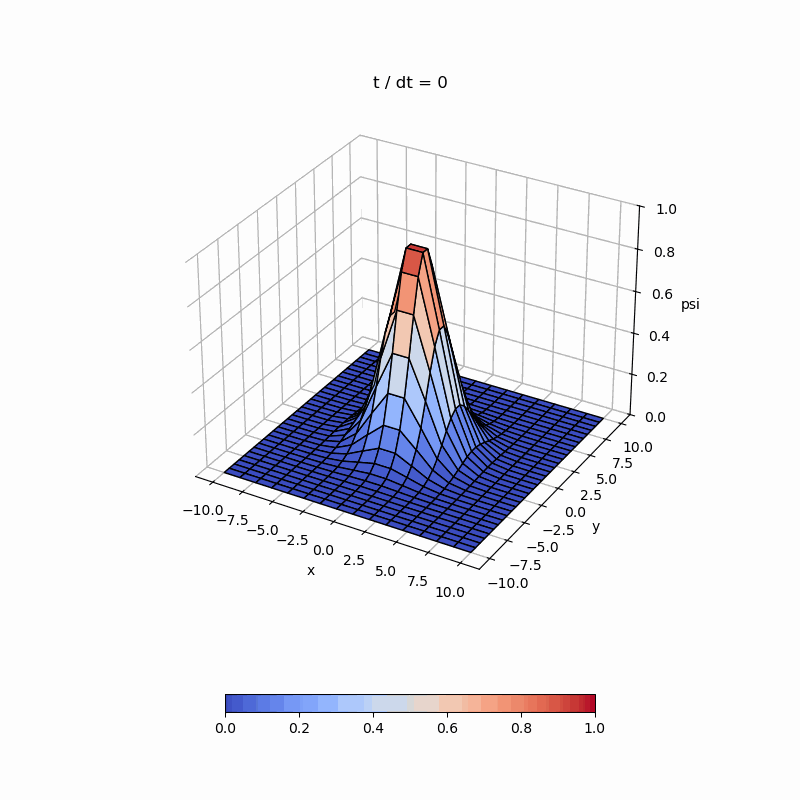

HTML(value="<a href='.\\tmp__vbq9rb.gif' target='_blank'>.\\tmp__vbq9rb.gif</a><br>")

In [18]:
def plot(n, zlim=(0, 1)):
    axs = (fig := pyplot.figure(figsize=(8, 8))).add_subplot(projection="3d")
    axs.set(xlabel="x", zlim=zlim, title=f"t / dt = {n}", ylabel="y", zlabel="psi")
    fig.colorbar(
        axs.plot_surface(
            *np.meshgrid(y, x),
            history[n],
            color='k',
            cmap=cm.coolwarm,
            norm=colors.Normalize(*zlim)
        ),
        fraction=0.03, location='bottom'
    )
    return fig
show_anim(plot, range(len(history)))

# Materiał na ćwiczenia:

#### 8. oszacowanie dyfuzji numerycznej (współczynnik $k$) wyrażone jako "antydyfuzyjna" liczba Couranta $\vec{D}=(D^{[x]}, D^{[y:]})$:

$$
\partial_t\psi + \partial_x \big(\!\!\!\!\!\!\!\!\!\!\!\!\underbrace{k \frac{\partial_x \psi}{\psi}}_\text{prędkość antydyfuzyjna} \!\!\!\!\!\!\!\!\!\!\!\!\psi\big) = 0
$$

$$
C^\text{[x]}_{i+\frac{1}{2},j }
= \frac{\Delta t}{\Delta x} k_{i+\frac{1}{2},j} \left.\frac{\partial_x \psi}{\psi}\right|_{i+\frac{1}{2},j}
\!\!\approx \left(|C^{[x]}_{i+\frac{1}{2},j}|-(C^{[x]}_{i+\frac{1}{2},j})^2\right)\underbrace{\frac{\psi_{i+1,j}-\psi_{i,j}}{\psi_{i+1,j}+\psi_{i,j}+\epsilon}}_{A_{i,j}} +
$$
$$- C^{[x]}_{i+\frac{1}{2},j} \underbrace{\frac{1}{2}\frac{\psi_{i+1,j+1}+\psi_{i,j+1}-\psi_{i+1,j-1}-\psi_{i,j-1}}{\psi_{i+1,j+1}+\psi_{i,j+1}+\psi_{i+1,j-1}+\psi_{i,j-1}+\epsilon}}_{B_{i,j}}\overbrace{\frac{C^{[y]}_{i+1,j+\frac{1}{2}}+C^{[y]}_{i,j+\frac{1}{2}}+C^{[y]}_{i+1,j-\frac{1}{2}}+C^{[y]}_{i,j-\frac{1}{2}}}{4}}^{\bar{C}_{i,j}}
$$

In [24]:
# TODO

9. całkowanie w czasie z krokiem korekcyjnym "odcałkowującym" dyfuzję numeryczną

In [25]:
set_initial_condition(solver)
history = []
for n in range(nt + 1):
    if n != 0:
        # krok UPWIND z "fizycznymi" liczbami Couranta
        set_courant_numbers(solver)
        solver.step()

        # krok korekcyjny UPWIND z "antydyfuzyjnymi" liczbami Couranta
        for d in (0, 1):
            solver.advector[d][:] = 0
            # TODO
        solver.step()
    history.append(solver.advectee.copy())

In [27]:
show_anim(plot, range(len(history)))